In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, make_scorer, roc_auc_score, f1_score
from sklearn import preprocessing
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, PredefinedSplit, GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def make_dataframe_impl(df_count, rolling=True):
    dfs_list = []
    dfs_rows_len_list = []

    file_name = ""
    if rolling is True:
        file_name = ".\\_datasets\\600s\\bt_rolling_dataset_"
    else:
        file_name = ".\\_datasets\\600s\\bt_sampling_dataset_"

    for i in range(1, df_count + 1):
        df = pd.read_csv(file_name + str(i) + ".csv")
        df = df.drop(["timestamp"], axis=1)

        df = (df - df.min()) / (df.max() - df.min())

        df["user"] = i
        dfs_list.append(df)
        dfs_rows_len_list.append(df.shape[0])

    df = pd.concat(dfs_list, ignore_index=True)
    return df

In [3]:
def make_common_rolling_dataframe(df_count):
    return make_dataframe_impl(df_count, True)


def make_common_sampling_dataframe(df_count):
    return make_dataframe_impl(df_count, False)

In [4]:
def drop_bad_rows(df):
    bad_rows = set()
    for col in df.columns:
        if col != "user":
            for user in df.user.unique():
                for x in list(
                    df.loc[df.user == user, :][
                        np.abs(stats.zscore(df.loc[df.user == user, col])) > 3
                    ].index
                ):
                    bad_rows.add(x)

            for x in list(df[col][np.abs(stats.zscore(df[col])) > 3].index):
                bad_rows.add(x)

    df.drop(list(bad_rows), axis=0, inplace=True)

    return df

def drop_bad_cols(df):
    bad_cols = set()
    for col in df.columns:
        if col != "user":
            if df[df[col] != df[col].mean()].shape[0] < 0.1 * df.shape[0]:
                bad_cols.add(col)

            for user in df.user.unique():
                if (
                    df.loc[df.user == user, :][
                        df.loc[df.user == user, col]
                        != df.loc[df.user == user, col].mean()
                    ].shape[0]
                    < 0.1 * df.loc[df.user == user, :].shape[0]
                ):
                    bad_cols.add(col)

                elif (
                    np.sum(np.abs(stats.zscore(df.loc[df.user == user, col])) < 3)
                    < 0.9 * df.loc[df.user == user, col].shape[0]
                ):
                    bad_cols.add(col)

    df.drop(list(bad_cols), axis=1, inplace=True)

    return df

In [5]:
def resample(df):
    sampling_dfs = []
    need_count = 0

    for label, count in zip(df.user.value_counts().index, df.user.value_counts().values):
        if need_count == 0:
            need_count = count
            df_ = df[df.user == label]
            sampling_dfs.append(df_)
        else:
            df_ = df[df.user == label]
            df_over = df_.sample(need_count, replace=True, random_state=42)
            sampling_dfs.append(df_over)

    new_df = pd.concat(sampling_dfs)
    new_df = new_df.reset_index()

    return pd.concat(sampling_dfs)

def extract_delayed_user(df, user_label):
    df_user = df[df["user"] == user_label]
    df = df[df["user"] != user_label]
    return df_user, df

def split_users_into_two_classes(df, valid_user_label):
    df.loc[df["user"] != valid_user_label, "user"] = 0
    df.loc[df["user"] == valid_user_label, "user"] = 1
    return df

In [6]:
def get_cv_split(X, y, group_labels, valid_user_label):
    predefined_split_array = np.zeros(group_labels.shape[0])
    i = 0
    test_array = [x for x in range(group_labels.shape[0])]
    for test, _ in LeaveOneGroupOut().split(X, y, group_labels):
        diff = np.setdiff1d(test_array, test)
        if np.all(group_labels[diff[0] : diff[-1]] == valid_user_label) is np.bool_(True):
            for sample in diff:
                predefined_split_array[sample] = -1
        else:
            for sample in diff:
                predefined_split_array[sample] = i
            i += 1
    return predefined_split_array

In [7]:
df = make_common_rolling_dataframe(8)

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [8]:
df.columns.to_list()

['acceleration_count_speed_mean_1_mad',
 'acceleration_count_speed_mean_1_mean',
 'acceleration_count_speed_mean_1_skew',
 'acceleration_count_speed_mean_2_mad',
 'acceleration_count_speed_mean_2_mean',
 'acceleration_count_speed_mean_2_skew',
 'acceleration_count_speed_mean_3_mad',
 'acceleration_count_speed_mean_3_mean',
 'acceleration_count_speed_mean_3_skew',
 'acceleration_count_speed_mean_mean_mad',
 'acceleration_count_speed_mean_mean_mean',
 'acceleration_count_speed_mean_mean_skew',
 'acceleration_count_speed_mean_median_mad',
 'acceleration_count_speed_mean_median_mean',
 'acceleration_count_speed_mean_median_skew',
 'acceleration_count_speed_mean_var_mad',
 'acceleration_count_speed_mean_var_mean',
 'acceleration_count_speed_mean_var_skew',
 'acceleration_disappeared_devices_count_mean_1_mad',
 'acceleration_disappeared_devices_count_mean_1_mean',
 'acceleration_disappeared_devices_count_mean_1_skew',
 'acceleration_disappeared_devices_count_mean_2_mad',
 'acceleration_disap

In [9]:
features = [
#  'acceleration_count_speed_mean_1_mad',
#  'acceleration_count_speed_mean_1_mean',
#  'acceleration_count_speed_mean_1_skew',
#  'acceleration_count_speed_mean_2_mad',
#  'acceleration_count_speed_mean_2_mean',
#  'acceleration_count_speed_mean_2_skew',
#  'acceleration_count_speed_mean_3_mad',
#  'acceleration_count_speed_mean_3_mean',
#  'acceleration_count_speed_mean_3_skew',
#  'acceleration_count_speed_mean_mean_mad',
#  'acceleration_count_speed_mean_mean_mean',
#  'acceleration_count_speed_mean_mean_skew',
#  'acceleration_count_speed_mean_median_mad',
#  'acceleration_count_speed_mean_median_mean',
#  'acceleration_count_speed_mean_median_skew',
#  'acceleration_count_speed_mean_var_mad',
#  'acceleration_count_speed_mean_var_mean',
#  'acceleration_count_speed_mean_var_skew',
#  'acceleration_disappeared_devices_count_mean_1_mad',
#  'acceleration_disappeared_devices_count_mean_1_mean',
#  'acceleration_disappeared_devices_count_mean_1_skew',
#  'acceleration_disappeared_devices_count_mean_2_mad',
#  'acceleration_disappeared_devices_count_mean_2_mean',
#  'acceleration_disappeared_devices_count_mean_2_skew',
#  'acceleration_disappeared_devices_count_mean_3_mad',
#  'acceleration_disappeared_devices_count_mean_3_mean',
#  'acceleration_disappeared_devices_count_mean_3_skew',
#  'acceleration_disappeared_devices_count_mean_mean_mad',
#  'acceleration_disappeared_devices_count_mean_mean_mean',
#  'acceleration_disappeared_devices_count_mean_mean_skew',
#  'acceleration_disappeared_devices_count_mean_median_mad',
#  'acceleration_disappeared_devices_count_mean_median_mean',
#  'acceleration_disappeared_devices_count_mean_median_skew',
#  'acceleration_disappeared_devices_count_mean_var_mad',
#  'acceleration_disappeared_devices_count_mean_var_mean',
#  'acceleration_disappeared_devices_count_mean_var_skew',
#  'acceleration_jaccard_index_mean_1_mad',
#  'acceleration_jaccard_index_mean_1_mean',
#  'acceleration_jaccard_index_mean_1_skew',
#  'acceleration_jaccard_index_mean_2_mad',
#  'acceleration_jaccard_index_mean_2_mean',
#  'acceleration_jaccard_index_mean_2_skew',
#  'acceleration_jaccard_index_mean_3_mad',
#  'acceleration_jaccard_index_mean_3_mean',
#  'acceleration_jaccard_index_mean_3_skew',
#  'acceleration_jaccard_index_mean_mean_mad',
#  'acceleration_jaccard_index_mean_mean_mean',
#  'acceleration_jaccard_index_mean_mean_skew',
#  'acceleration_jaccard_index_mean_median_mad',
#  'acceleration_jaccard_index_mean_median_mean',
#  'acceleration_jaccard_index_mean_median_skew',
#  'acceleration_jaccard_index_mean_var_mad',
#  'acceleration_jaccard_index_mean_var_mean',
#  'acceleration_jaccard_index_mean_var_skew',
#  'acceleration_occur_speed_mean_1_mad',
#  'acceleration_occur_speed_mean_1_mean',
#  'acceleration_occur_speed_mean_1_skew',
#  'acceleration_occur_speed_mean_2_mad',
#  'acceleration_occur_speed_mean_2_mean',
#  'acceleration_occur_speed_mean_2_skew',
#  'acceleration_occur_speed_mean_3_mad',
#  'acceleration_occur_speed_mean_3_mean',
#  'acceleration_occur_speed_mean_3_skew',
#  'acceleration_occur_speed_mean_mean_mad',
#  'acceleration_occur_speed_mean_mean_mean',
#  'acceleration_occur_speed_mean_mean_skew',
#  'acceleration_occur_speed_mean_median_mad',
#  'acceleration_occur_speed_mean_median_mean',
#  'acceleration_occur_speed_mean_median_skew',
#  'acceleration_occur_speed_mean_var_mad',
#  'acceleration_occur_speed_mean_var_mean',
#  'acceleration_occur_speed_mean_var_skew',
#  'acceleration_occured_devices_count_mean_1_mad',
#  'acceleration_occured_devices_count_mean_1_mean',
#  'acceleration_occured_devices_count_mean_1_skew',
#  'acceleration_occured_devices_count_mean_2_mad',
#  'acceleration_occured_devices_count_mean_2_mean',
#  'acceleration_occured_devices_count_mean_2_skew',
#  'acceleration_occured_devices_count_mean_3_mad',
#  'acceleration_occured_devices_count_mean_3_mean',
#  'acceleration_occured_devices_count_mean_3_skew',
#  'acceleration_occured_devices_count_mean_mean_mad',
#  'acceleration_occured_devices_count_mean_mean_mean',
#  'acceleration_occured_devices_count_mean_mean_skew',
#  'acceleration_occured_devices_count_mean_median_mad',
#  'acceleration_occured_devices_count_mean_median_mean',
#  'acceleration_occured_devices_count_mean_median_skew',
#  'acceleration_occured_devices_count_mean_var_mad',
#  'acceleration_occured_devices_count_mean_var_mean',
#  'acceleration_occured_devices_count_mean_var_skew',
 'count_kurt',
 'count_mean',
 'count_median',
 'count_skew',
#  'count_speed_1_mad',
#  'count_speed_1_mean',
#  'count_speed_1_skew',
#  'count_speed_2_mad',
#  'count_speed_2_mean',
#  'count_speed_2_skew',
#  'count_speed_3_mad',
#  'count_speed_3_mean',
#  'count_speed_3_skew',
 'count_speed_mean_mad',
 'count_speed_mean_mean',
 'count_speed_mean_skew',
 'count_speed_median_mad',
 'count_speed_median_mean',
 'count_speed_median_skew',
 'count_speed_var_mad',
 'count_speed_var_mean',
 'count_speed_var_skew',
 'count_var',
#  'disappeared_devices_count_1_mad',
#  'disappeared_devices_count_1_mean',
#  'disappeared_devices_count_1_skew',
#  'disappeared_devices_count_2_mad',
#  'disappeared_devices_count_2_mean',
#  'disappeared_devices_count_2_skew',
#  'disappeared_devices_count_3_mad',
#  'disappeared_devices_count_3_mean',
#  'disappeared_devices_count_3_skew',
 'disappeared_devices_count_mean_mad',
 'disappeared_devices_count_mean_mean',
 'disappeared_devices_count_mean_skew',
 'disappeared_devices_count_median_mad',
 'disappeared_devices_count_median_mean',
 'disappeared_devices_count_median_skew',
 'disappeared_devices_count_var_mad',
 'disappeared_devices_count_var_mean',
 'disappeared_devices_count_var_skew',
#  'jaccard_index_1_mad',
#  'jaccard_index_1_mean',
#  'jaccard_index_1_skew',
#  'jaccard_index_2_mad',
#  'jaccard_index_2_mean',
#  'jaccard_index_2_skew',
#  'jaccard_index_3_mad',
#  'jaccard_index_3_mean',
#  'jaccard_index_3_skew',
 'jaccard_index_mean_mad',
 'jaccard_index_mean_mean',
 'jaccard_index_mean_skew',
 'jaccard_index_median_mad',
 'jaccard_index_median_mean',
 'jaccard_index_median_skew',
 'jaccard_index_var_mad',
 'jaccard_index_var_mean',
 'jaccard_index_var_skew',
 'le_connectable_kurt',
 'le_connectable_mean',
 'le_connectable_median',
 'le_connectable_skew',
 'le_connectable_var',
 'le_level_kurt',
 'le_level_mean',
 'le_level_median',
 'le_level_skew',
 'le_level_var',
#  'occur_speed_1_mad',
#  'occur_speed_1_mean',
#  'occur_speed_1_skew',
#  'occur_speed_2_mad',
#  'occur_speed_2_mean',
#  'occur_speed_2_skew',
#  'occur_speed_3_mad',
#  'occur_speed_3_mean',
#  'occur_speed_3_skew',
 'occur_speed_mean_mad',
 'occur_speed_mean_mean',
 'occur_speed_mean_skew',
 'occur_speed_median_mad',
 'occur_speed_median_mean',
 'occur_speed_median_skew',
 'occur_speed_var_mad',
 'occur_speed_var_mean',
 'occur_speed_var_skew',
#  'occured_devices_count_1_mad',
#  'occured_devices_count_1_mean',
#  'occured_devices_count_1_skew',
#  'occured_devices_count_2_mad',
#  'occured_devices_count_2_mean',
#  'occured_devices_count_2_skew',
#  'occured_devices_count_3_mad',
#  'occured_devices_count_3_mean',
#  'occured_devices_count_3_skew',
 'occured_devices_count_mean_mad',
 'occured_devices_count_mean_mean',
 'occured_devices_count_mean_skew',
 'occured_devices_count_median_mad',
 'occured_devices_count_median_mean',
 'occured_devices_count_median_skew',
 'occured_devices_count_var_mad',
 'occured_devices_count_var_mean',
 'occured_devices_count_var_skew',
#  'one_hot_b_10_kurt',
#  'one_hot_b_10_mean',
#  'one_hot_b_10_median',
#  'one_hot_b_10_skew',
#  'one_hot_b_10_var',
#  'one_hot_b_12_kurt',
#  'one_hot_b_12_mean',
#  'one_hot_b_12_median',
#  'one_hot_b_12_skew',
#  'one_hot_b_12_var',
#  'one_hot_c_0_kurt',
#  'one_hot_c_0_mean',
#  'one_hot_c_0_median',
#  'one_hot_c_0_skew',
#  'one_hot_c_0_var',
#  'one_hot_c_1024_kurt',
#  'one_hot_c_1024_mean',
#  'one_hot_c_1024_median',
#  'one_hot_c_1024_skew',
#  'one_hot_c_1024_var',
#  'one_hot_c_1280_kurt',
#  'one_hot_c_1280_mean',
#  'one_hot_c_1280_median',
#  'one_hot_c_1280_skew',
#  'one_hot_c_1280_var',
#  'one_hot_c_1536_kurt',
#  'one_hot_c_1536_mean',
#  'one_hot_c_1536_median',
#  'one_hot_c_1536_skew',
#  'one_hot_c_1536_var',
#  'one_hot_c_1792_kurt',
#  'one_hot_c_1792_mean',
#  'one_hot_c_1792_median',
#  'one_hot_c_1792_skew',
#  'one_hot_c_1792_var',
#  'one_hot_c_256_kurt',
#  'one_hot_c_256_mean',
#  'one_hot_c_256_median',
#  'one_hot_c_256_skew',
#  'one_hot_c_256_var',
#  'one_hot_c_512_kurt',
#  'one_hot_c_512_mean',
#  'one_hot_c_512_median',
#  'one_hot_c_512_skew',
#  'one_hot_c_512_var',
#  'one_hot_c_7936_kurt',
#  'one_hot_c_7936_mean',
#  'one_hot_c_7936_median',
#  'one_hot_c_7936_skew',
#  'one_hot_c_7936_var',
#  'one_hot_t_0_kurt',
#  'one_hot_t_0_mean',
#  'one_hot_t_0_median',
#  'one_hot_t_0_skew',
#  'one_hot_t_0_var',
#  'one_hot_t_1_kurt',
#  'one_hot_t_1_mean',
#  'one_hot_t_1_median',
#  'one_hot_t_1_skew',
#  'one_hot_t_1_var',
#  'one_hot_t_2_kurt',
#  'one_hot_t_2_mean',
#  'one_hot_t_2_median',
#  'one_hot_t_2_skew',
#  'one_hot_t_2_var',
#  'one_hot_t_3_kurt',
#  'one_hot_t_3_mean',
#  'one_hot_t_3_median',
#  'one_hot_t_3_skew',
#  'one_hot_t_3_var',
 'user']

In [10]:
df = df.drop(df.columns.difference(features), axis=1)
df = df.dropna(how='all')
df = df.fillna(0)

In [13]:
df = drop_bad_cols(df)
df = drop_bad_rows(df)

Text(0.5, -0.03, 'Correlation matrix')

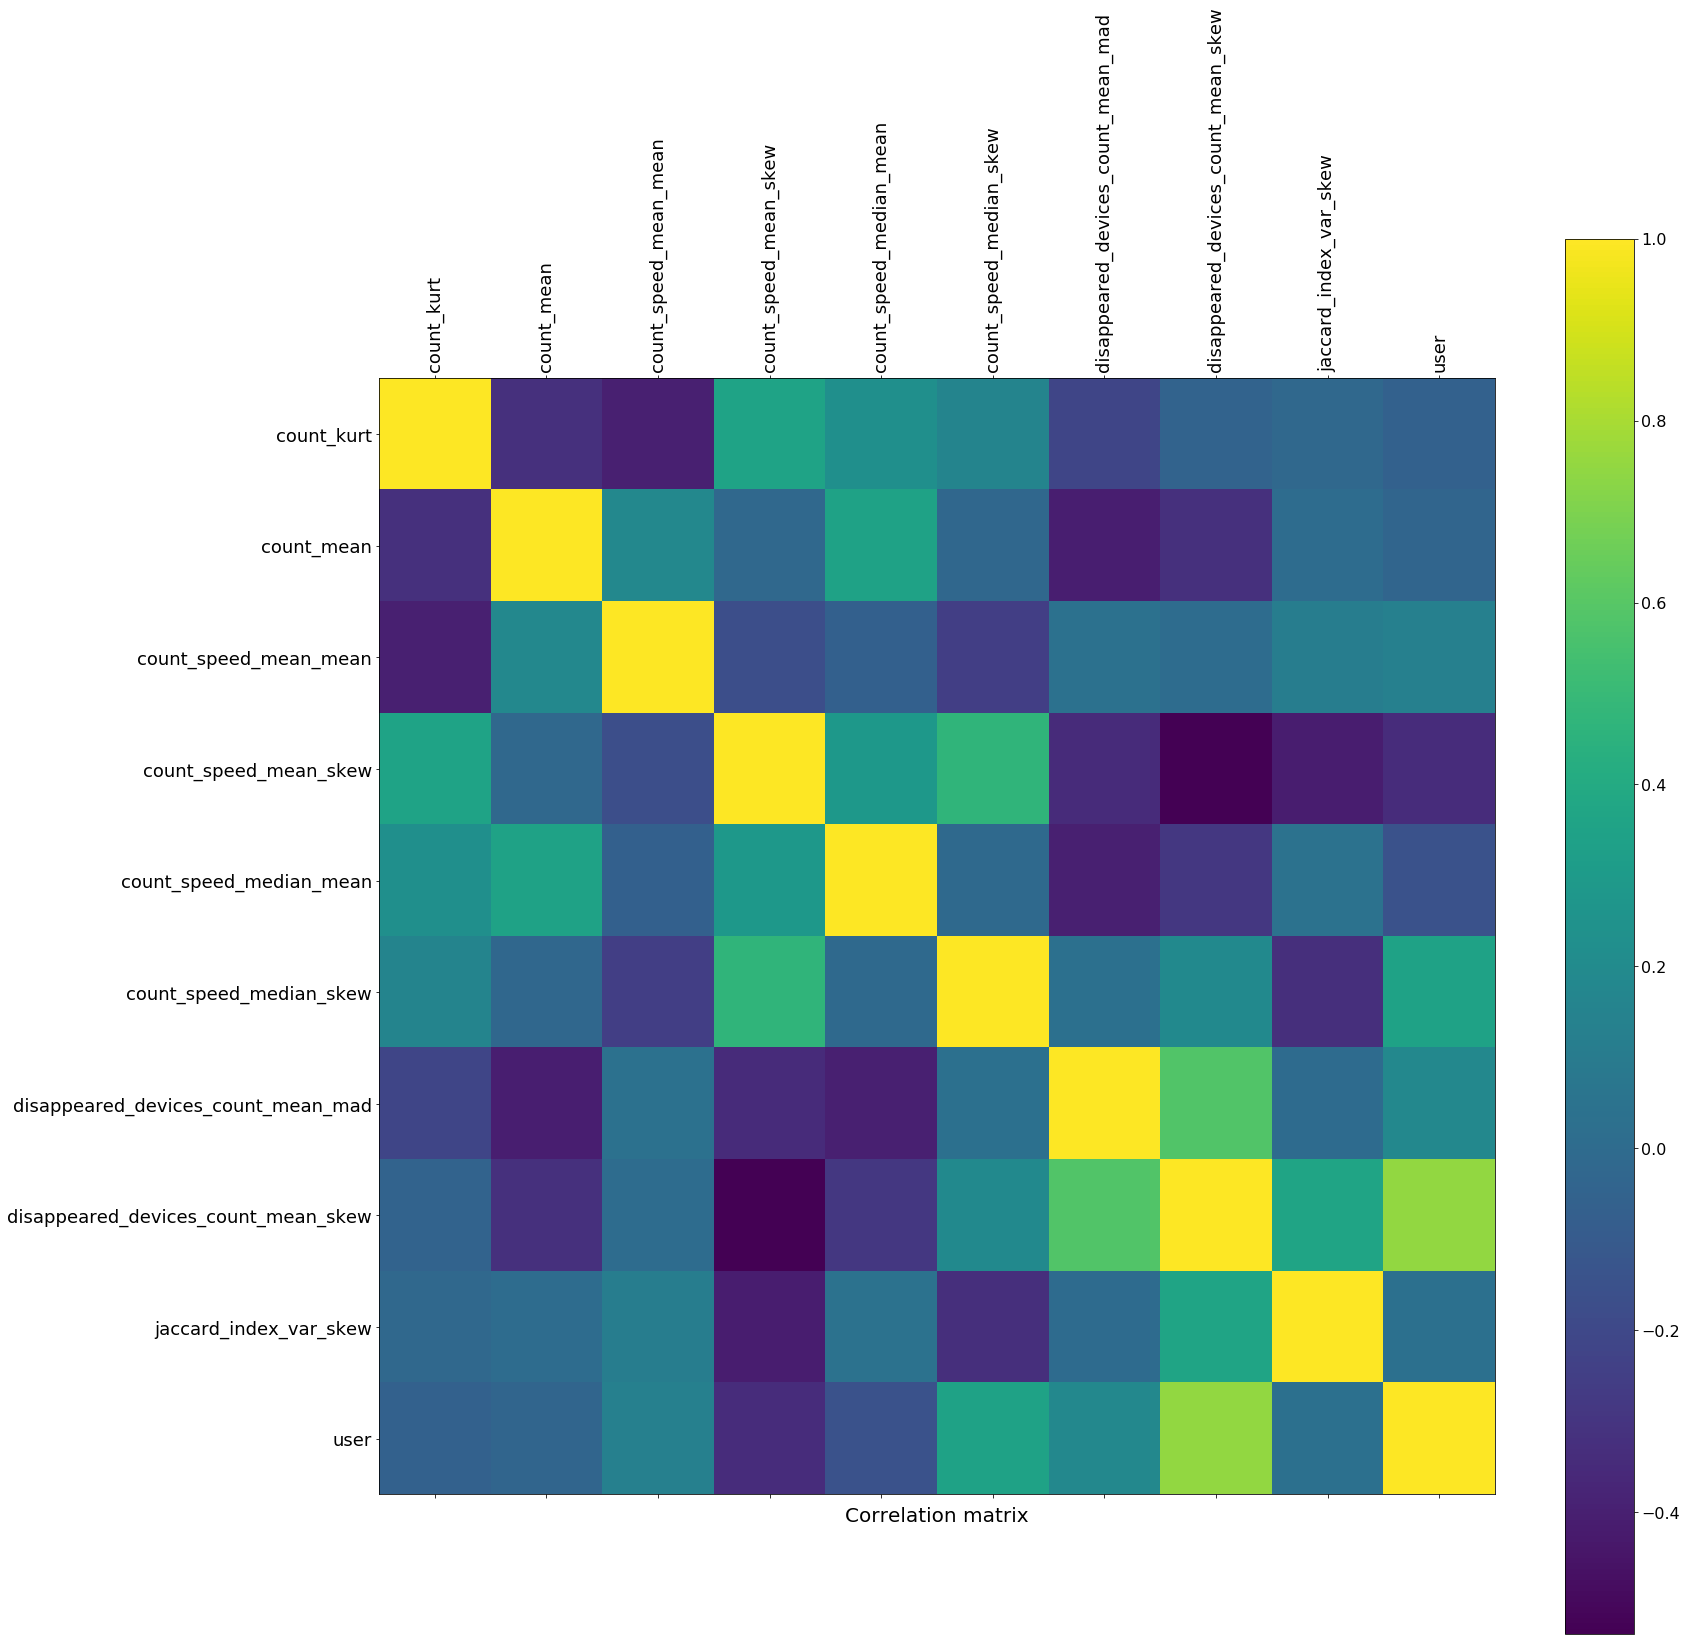

In [35]:
fig = plt.figure(figsize=(25, 25))
plt.matshow(df.corr(), fignum=fig.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=18, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.title("Correlation matrix", fontsize=20, y=-0.03)

In [31]:
corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_cols = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.7) and column != "user"]
df = df.drop(corr_cols, axis=1)

In [32]:
# df.drop('user', axis=1).boxplot()

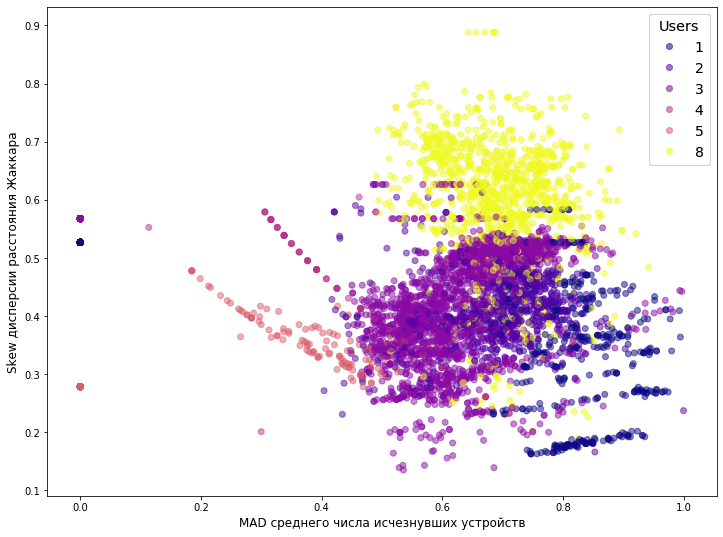

In [14]:
sample = df.sample(10000)

fig, ax = plt.subplots(figsize=(12, 9))

scatter = ax.scatter(x=sample['disappeared_devices_count_mean_mad'], y=sample['jaccard_index_var_skew'], \
                     alpha=0.5, c=sample.user, cmap='plasma')

# produce a legend with the unique colors from the scatter
plt.rcParams['legend.title_fontsize'] = 'x-large'
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Users", fontsize=14)
ax.add_artist(legend1)

plt.xlabel('MAD среднего числа исчезнувших устройств', fontsize=12)
plt.ylabel('Skew дисперсии расстояния Жаккара', fontsize=12)

plt.savefig('.\\after.png', dpi=500)
plt.show()

In [21]:
C = 1
kernel = 'rbf'
degree = 1
gamma = 5

user = 8

df['labels'] = df['user']

df_ = resample(df.copy())
df_ = split_users_into_two_classes(df_.copy(), user)
df_ = resample(df_)
    
df_.loc[df_.user == 0, 'user'] = -1
    
df_ = df_.drop('labels', axis=1)
    
model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)

In [22]:
df_.shape

(198336, 61)

In [23]:
df_.columns

Index(['count_kurt', 'count_mean', 'count_median', 'count_skew',
       'count_speed_mean_mad', 'count_speed_mean_mean',
       'count_speed_mean_skew', 'count_speed_median_mad',
       'count_speed_median_mean', 'count_speed_median_skew',
       'count_speed_var_mad', 'count_speed_var_mean', 'count_speed_var_skew',
       'count_var', 'disappeared_devices_count_mean_mad',
       'disappeared_devices_count_mean_mean',
       'disappeared_devices_count_mean_skew',
       'disappeared_devices_count_median_mad',
       'disappeared_devices_count_median_mean',
       'disappeared_devices_count_median_skew',
       'disappeared_devices_count_var_mad',
       'disappeared_devices_count_var_mean',
       'disappeared_devices_count_var_skew', 'jaccard_index_mean_mad',
       'jaccard_index_mean_mean', 'jaccard_index_mean_skew',
       'jaccard_index_median_mad', 'jaccard_index_median_mean',
       'jaccard_index_median_skew', 'jaccard_index_var_mad',
       'jaccard_index_var_mean', 'jaccard_i

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


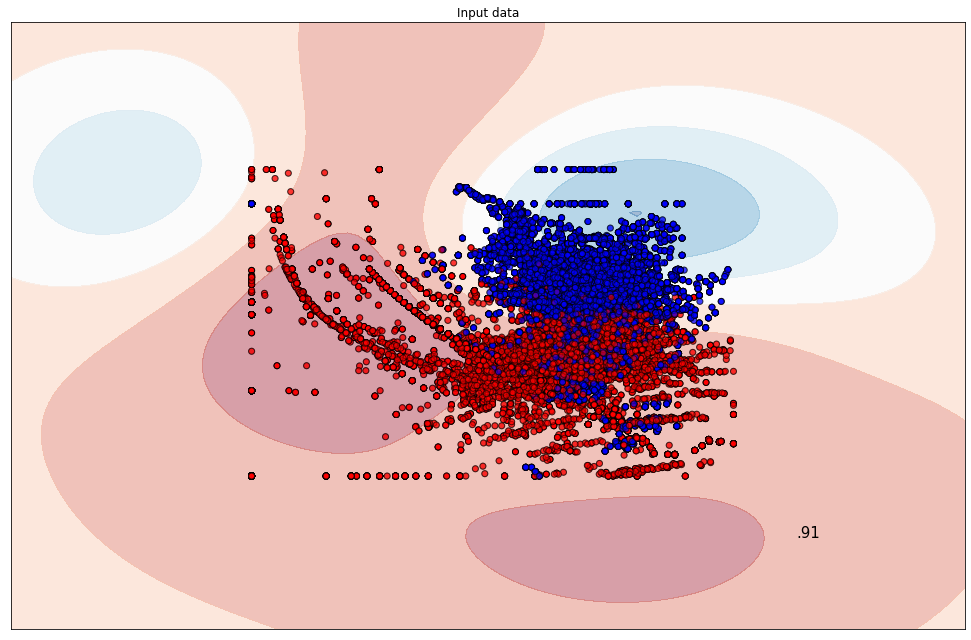

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

figure = plt.figure(figsize=(27, 9))
i = 1

ds = df_.to_numpy().copy()
np.random.shuffle(ds)

X = ds[:, :-1]
y = ds[:, -1]

X_train = X[:10000, [14, 31]]
y_train = y[:10000]

X_test = X[160000:, [14, 31]]
y_test = y[160000:]

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

xx, yy = np.meshgrid(
                    np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, 2, 1)
ax.set_title("Input data")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
            edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1, 1 + 1, 1)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

if hasattr(model, "decision_function"):
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.4)

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
# ax.set_title(name)
ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')

plt.tight_layout()
plt.show()

In [25]:
xx, yy = np.meshgrid(
                    np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h),
                   )

In [26]:
xx.shape

(100, 100)

In [27]:
Z

array([[0.25044821, 0.24464787, 0.2384792 , ..., 0.05865372, 0.0836637 ,
        0.106776  ],
       [0.24472685, 0.23831296, 0.2314902 , ..., 0.03580603, 0.06298355,
        0.08811731],
       [0.23866927, 0.23160425, 0.22408707, ..., 0.01229369, 0.04167035,
        0.06885924],
       ...,
       [0.7852768 , 0.82609847, 0.86774948, ..., 0.36445564, 0.35803841,
        0.35214634],
       [0.73633461, 0.77307201, 0.8105716 , ..., 0.35514291, 0.34973481,
        0.34476847],
       [0.69074433, 0.72366262, 0.75727727, ..., 0.34709474, 0.34255958,
        0.33839403]])

In [16]:
# for user in df.user.unique():
#     for valid_user in df.user.unique():
#         if user != valid_user:
#             print('---------------------------------------------------------------------------')
#             print('Valid user: ', valid_user, 'Extracted user: ', user)
#             print('---------------------------------------------------------------------------')
#             df1, df_ = extract_delayed_user(df.copy(), user)
#             df1['user'] = 0
#             df_ = split_users_into_two_classes(df_.copy(), valid_user)
#             df_ = resample(df_)

#             dataset = df_.to_numpy()
#             X = dataset[:, :-1]
#             y = dataset[:, -1]

#             X_test = df1.to_numpy()[:, :-1]
#             y_test = df1.to_numpy()[:, -1]
            
#             model = CatBoostClassifier(iterations=100, depth=6, loss_function='Logloss')
#             model.fit(X, y, verbose=False)

#             preds_class = model.predict(X_test)
#             print('Accuracy: ', accuracy_score(preds_class, y_test))

#             sum_ = 0
#             imp = [ (x, i) for x, i in zip(model.feature_importances_, range(len(model.feature_importances_)) )]
#             sorted_ = sorted(imp, key=lambda tup: tup[0])
#             for i in range(len(sorted_)):
#                 if sorted_[i][0] > 5:
#                     print(sorted_[i][1], ': ', df_.columns[sorted_[i][1]], ' - ', sorted_[i][0])

#             print('---------------------------------------------------------------------------')
#             print('---------------------------------------------------------------------------')

## CatBoostClassifier CV

In [17]:
iterations = 100
depth = 6
loss_function = 'Logloss'
l2_leaf_reg = 1
leaf_estimation_iterations = 5
logging_level = 'Silent'

df['labels'] = df['user']

CV_CATBOOST_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    df_ = resample(df.copy())
    df_ = split_users_into_two_classes(df_.copy(), user)
    df_ = resample(df_)
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))
    scoring = ('accuracy', 'balanced_accuracy')
    
    model = CatBoostClassifier(iterations=iterations, depth=depth, loss_function=loss_function, \
                               l2_leaf_reg=l2_leaf_reg, leaf_estimation_iterations=leaf_estimation_iterations,\
                               logging_level=logging_level)
    
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv_split, n_jobs=-1)
    accuracy = cv_results['test_accuracy']
    
    CV_CATBOOST_BIG_DICT[str(user)] = {}
    CV_CATBOOST_BIG_DICT[str(user)]["accuracy"] = accuracy.copy()
    CV_CATBOOST_BIG_DICT[str(user)]["mean_accuracy"] = np.mean(accuracy).copy()
    CV_CATBOOST_BIG_DICT[str(user)]["max_accuracy"] = np.max(accuracy).copy()
    CV_CATBOOST_BIG_DICT[str(user)]["min_accuracy"] = np.min(accuracy).copy()
    
    print("CV accuracy list: ", accuracy)
    print("CV mean accuracy: ", np.mean(accuracy))
    print("CV min accuracy: ", np.min(accuracy))
    print("CV max accuracy: ", np.max(accuracy))
    
    print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
CV accuracy list:  [1.         0.02898551 1.         1.         1.         1.        ]
CV mean accuracy:  0.8381642512077295
CV min accuracy:  0.028985507246376812
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  2
--------------------------------------------------------------------------------
CV accuracy list:  [0.98550725 1.         0.9468599  0.42995169 1.         0.5410628 ]
CV mean accuracy:  0.8172302737520128
CV min accuracy:  0.42995169082125606
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  3
--------------------------------------------------------------------------------
CV accuracy list:  [0.         1.         0.         1.         1.         0.61352657]
CV mean accuracy:  0.6022544283413849
CV min accuracy:  0.0
CV max accuracy:  1.0
----------

## CatBoostClassifier Final Validation

In [18]:
iterations = 100
depth = 6
loss_function = 'Logloss'
l2_leaf_reg = 1
leaf_estimation_iterations = 5
logging_level = 'Silent'

df["labels"] = df["user"]

VALIDATION_CATBOOST_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    VALIDATION_CATBOOST_BIG_DICT[str(user)] = {}

    for ex_user in df.labels.unique():
        if ex_user != user:

            df_ = df.copy()

            df_for_test = []

            df__ = df_[df_.labels == ex_user].copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

            for user_ in df_.labels.unique():
                if user_ != ex_user:
                    test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
                    df__ = df_[df_.labels == user_].sample(test_size).copy()
                    df_for_test.append(df__)
                    df_ = df_.drop(df__.index, axis=0)

            df_ = resample(df_.copy())
            df_ = split_users_into_two_classes(df_.copy(), user)
            df_ = resample(df_)

            df_ = df_.drop("labels", axis=1)

            dataset = df_.to_numpy().copy()
            np.random.shuffle(dataset)

            X = dataset[:, :-1]
            y = dataset[:, -1]

            model = CatBoostClassifier(iterations=iterations, depth=depth, loss_function=loss_function, \
                                       l2_leaf_reg=l2_leaf_reg, leaf_estimation_iterations=leaf_estimation_iterations, \
                                       logging_level=logging_level)
            model.fit(X, y)

            # Testing

            test_df = pd.concat(df_for_test)

            valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
            ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
            others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                                    for x in test_df.labels.unique() if x != user and x != ex_user]

            min_others_test_count = min(others_in_test_count)

            is_important_min = True
            if min_others_test_count <= ex_user_in_test_count and min_others_test_count <= valid_user_in_test_count:
                is_important_min = False

            new_df_parts = []
            if is_important_min is True:
                part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                other_sample_size = part_size // len(others_in_test_count) + 1

            else:
                part_size_can_be = min_others_test_count * len(others_in_test_count)
                        
                if part_size_can_be > min(valid_user_in_test_count, ex_user_in_test_count):
                    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                    other_sample_size = part_size // len(others_in_test_count) + 1
                else:
                    part_size = part_size_can_be
                    other_sample_size = min_others_test_count
                    
            new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
            new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())

            for x in test_df.labels.unique():
                if x != user and x != ex_user:
                    new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
            test_df = pd.concat(new_df_parts)

            test_df.loc[test_df.labels != user, "user"] = 0
            test_df.loc[test_df.labels == user, "user"] = 1

            print("True: ", test_df[test_df.user == 1].shape)
            print("Shape: ", test_df.shape)
            for x in test_df.labels.unique():
                print("Count ", x, ": ", test_df[test_df.labels == x].shape)

            test_df = test_df.drop("labels", axis=1)

            test_dataset = test_df.to_numpy().copy()
            X_test = test_dataset[:, :-1].copy()
            y_test = test_dataset[:, -1].copy()
            
            VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user] = {}
            VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_test"] = y_test.copy()
            VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_predict"] = model.predict(X_test).copy()
            VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_proba"] = model.predict_proba(X_test).copy()

            print("Valid user = ", user, ", Extracted user = ", ex_user, "accuracy = ",
                    accuracy_score(VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_test"], 
                                   VALIDATION_CATBOOST_BIG_DICT[str(user)][ex_user]["y_predict"])
                 )

            print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
True:  (24, 13)
Shape:  (72, 13)
Count  1 :  (24, 13)
Count  2 :  (24, 13)
Count  3 :  (6, 13)
Count  4 :  (6, 13)
Count  5 :  (6, 13)
Count  8 :  (6, 13)
Valid user =  1 , Extracted user =  2 accuracy =  1.0
--------------------------------------------------------------------------------
True:  (24, 13)
Shape:  (72, 13)
Count  1 :  (24, 13)
Count  3 :  (24, 13)
Count  2 :  (6, 13)
Count  4 :  (6, 13)
Count  5 :  (6, 13)
Count  8 :  (6, 13)
Valid user =  1 , Extracted user =  3 accuracy =  0.6666666666666666
--------------------------------------------------------------------------------
True:  (28, 13)
Shape:  (88, 13)
Count  1 :  (28, 13)
Count  4 :  (28, 13)
Count  2 :  (8, 13)
Count  3 :  (8, 13)
Count  5 :  (8, 13)
Count  8 :  (8, 13)
Valid user =  1 , Extracted user =  4 accuracy =  0.9886363636363636
--------------------------------------------------------------------------------
True

True:  (24, 13)
Shape:  (72, 13)
Count  5 :  (24, 13)
Count  3 :  (24, 13)
Count  1 :  (6, 13)
Count  2 :  (6, 13)
Count  4 :  (6, 13)
Count  8 :  (6, 13)
Valid user =  5 , Extracted user =  3 accuracy =  0.9722222222222222
--------------------------------------------------------------------------------
True:  (28, 13)
Shape:  (88, 13)
Count  5 :  (28, 13)
Count  4 :  (28, 13)
Count  1 :  (8, 13)
Count  2 :  (8, 13)
Count  3 :  (8, 13)
Count  8 :  (8, 13)
Valid user =  5 , Extracted user =  4 accuracy =  1.0
--------------------------------------------------------------------------------
True:  (4, 13)
Shape:  (13, 13)
Count  5 :  (4, 13)
Count  7 :  (4, 13)
Count  1 :  (1, 13)
Count  2 :  (1, 13)
Count  3 :  (1, 13)
Count  4 :  (1, 13)
Count  8 :  (1, 13)
Valid user =  5 , Extracted user =  7 accuracy =  0.6923076923076923
--------------------------------------------------------------------------------
True:  (24, 13)
Shape:  (72, 13)
Count  5 :  (24, 13)
Count  8 :  (24, 13)
Count  1

## RandomForestClassifier CV

In [19]:
n_estimators = 100
criterion = 'gini'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
max_features = 'auto'
n_jobs = -1
class_weight = 'balanced'

df['labels'] = df['user']

CV_RFC_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    df_ = resample(df.copy())
    df_ = split_users_into_two_classes(df_.copy(), user)
    df_ = resample(df_)
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))
    scoring = ('accuracy', 'balanced_accuracy')
    
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, \
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                                   max_features=max_features, n_jobs=n_jobs, class_weight=class_weight)
    
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv_split, n_jobs=-1)
    accuracy = cv_results['test_accuracy']
    
    CV_RFC_BIG_DICT[str(user)] = {}
    CV_RFC_BIG_DICT[str(user)]["accuracy"] = accuracy.copy()
    CV_RFC_BIG_DICT[str(user)]["mean_accuracy"] = np.mean(accuracy).copy()
    CV_RFC_BIG_DICT[str(user)]["max_accuracy"] = np.max(accuracy).copy()
    CV_RFC_BIG_DICT[str(user)]["min_accuracy"] = np.min(accuracy).copy()
    
    print("CV accuracy list: ", accuracy)
    print("CV mean accuracy: ", np.mean(accuracy))
    print("CV min accuracy: ", np.min(accuracy))
    print("CV max accuracy: ", np.max(accuracy))
    
    print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
CV accuracy list:  [1.         0.14009662 1.         1.         1.         1.        ]
CV mean accuracy:  0.8566827697262479
CV min accuracy:  0.14009661835748793
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  2
--------------------------------------------------------------------------------
CV accuracy list:  [1.         1.         1.         0.69565217 1.         0.76811594]
CV mean accuracy:  0.9106280193236714
CV min accuracy:  0.6956521739130435
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  3
--------------------------------------------------------------------------------
CV accuracy list:  [0.04830918 1.         1.         1.         1.         0.95169082]
CV mean accuracy:  0.8333333333333334
CV min accuracy:  0.04830917874396135
CV max accuracy:  

## RandomForestClassifier Final Validation

In [20]:
n_estimators = 100
criterion = 'gini'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
max_features = 'auto'
n_jobs = -1
class_weight = 'balanced'

df["labels"] = df["user"]

VALIDATION_RFC_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    VALIDATION_RFC_BIG_DICT[str(user)] = {}

    for ex_user in df.labels.unique():
        if ex_user != user:

            df_ = df.copy()

            df_for_test = []

            df__ = df_[df_.labels == ex_user].copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

            for user_ in df_.labels.unique():
                if user_ != ex_user:
                    test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
                    df__ = df_[df_.labels == user_].sample(test_size).copy()
                    df_for_test.append(df__)
                    df_ = df_.drop(df__.index, axis=0)

            df_ = resample(df_.copy())
            df_ = split_users_into_two_classes(df_.copy(), user)
            df_ = resample(df_)

            df_ = df_.drop("labels", axis=1)

            dataset = df_.to_numpy().copy()
            np.random.shuffle(dataset)

            X = dataset[:, :-1]
            y = dataset[:, -1]

            model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, \
                                           min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                                           max_features=max_features, n_jobs=n_jobs, class_weight=class_weight)
            model.fit(X, y)

            # Testing

            test_df = pd.concat(df_for_test)

            valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
            ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
            others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                                    for x in test_df.labels.unique() if x != user and x != ex_user]

            min_others_test_count = min(others_in_test_count)

            is_important_min = True
            if min_others_test_count <= ex_user_in_test_count and min_others_test_count <= valid_user_in_test_count:
                is_important_min = False

            new_df_parts = []
            if is_important_min is True:
                part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                other_sample_size = part_size // len(others_in_test_count) + 1

            else:
                part_size_can_be = min_others_test_count * len(others_in_test_count)
                        
                if part_size_can_be > min(valid_user_in_test_count, ex_user_in_test_count):
                    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                    other_sample_size = part_size // len(others_in_test_count) + 1
                else:
                    part_size = part_size_can_be
                    other_sample_size = min_others_test_count
                    
            new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
            new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())

            for x in test_df.labels.unique():
                if x != user and x != ex_user:
                    new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
            test_df = pd.concat(new_df_parts)

            test_df.loc[test_df.labels != user, "user"] = 0
            test_df.loc[test_df.labels == user, "user"] = 1

            test_df = test_df.drop("labels", axis=1)

            test_dataset = test_df.to_numpy().copy()
            X_test = test_dataset[:, :-1].copy()
            y_test = test_dataset[:, -1].copy()

            VALIDATION_RFC_BIG_DICT[str(user)][ex_user] = {}
            VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_test"] = y_test.copy()
            VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_predict"] = model.predict(X_test).copy()
            VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_proba"] = model.predict_proba(X_test).copy()

            print("Valid user = ", user, ", Extracted user = ", ex_user, "accuracy = ",
                    accuracy_score(VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_test"], 
                                   VALIDATION_RFC_BIG_DICT[str(user)][ex_user]["y_predict"])
                 )

            print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  2 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  3 accuracy =  0.7777777777777778
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  4 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  5 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  7 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  8 accuracy =  0.9722222222222222
--------------------------------------------------------------------------------
Valid User:  2
-------------------------------------------------

## SVC CV

In [21]:
C = 1
kernel = 'rbf'
degree = 1
gamma = 5

df['labels'] = df['user']

CV_SVC_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    df_ = resample(df.copy())
    df_ = split_users_into_two_classes(df_.copy(), user)
    df_ = resample(df_)
    
    df_.loc[df_.user == 0, 'user'] = -1
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))
    scoring = ('accuracy', 'balanced_accuracy')
    
    model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv_split, n_jobs=-1)
    accuracy = cv_results['test_accuracy']
    
    CV_SVC_BIG_DICT[str(user)] = {}
    CV_SVC_BIG_DICT[str(user)]["accuracy"] = accuracy.copy()
    CV_SVC_BIG_DICT[str(user)]["mean_accuracy"] = np.mean(accuracy).copy()
    CV_SVC_BIG_DICT[str(user)]["max_accuracy"] = np.max(accuracy).copy()
    CV_SVC_BIG_DICT[str(user)]["min_accuracy"] = np.min(accuracy).copy()
    
    print("CV accuracy list: ", accuracy)
    print("CV mean accuracy: ", np.mean(accuracy))
    print("CV min accuracy: ", np.min(accuracy))
    print("CV max accuracy: ", np.max(accuracy))
    
    print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
CV accuracy list:  [1.         0.55555556 1.         1.         1.         1.        ]
CV mean accuracy:  0.9259259259259259
CV min accuracy:  0.5555555555555556
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  2
--------------------------------------------------------------------------------
CV accuracy list:  [1.         1.         1.         0.87439614 1.         0.80676329]
CV mean accuracy:  0.9468599033816424
CV min accuracy:  0.8067632850241546
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  3
--------------------------------------------------------------------------------
CV accuracy list:  [0.39130435 1.         1.         1.         1.         0.86956522]
CV mean accuracy:  0.8768115942028986
CV min accuracy:  0.391304347826087
CV max accuracy:  1.0

## SVC Final Validation

In [22]:
C = 1
kernel = 'rbf'
degree = 1
gamma = 5

df["labels"] = df["user"]

VALIDATION_SVC_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    VALIDATION_SVC_BIG_DICT[str(user)] = {}

    for ex_user in df.labels.unique():
        if ex_user != user:

            df_ = df.copy()

            df_for_test = []

            df__ = df_[df_.labels == ex_user].copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

            for user_ in df_.labels.unique():
                if user_ != ex_user:
                    test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
                    df__ = df_[df_.labels == user_].sample(test_size).copy()
                    df_for_test.append(df__)
                    df_ = df_.drop(df__.index, axis=0)

            df_ = resample(df_.copy())
            df_ = split_users_into_two_classes(df_.copy(), user)
            df_ = resample(df_)
            
            df_.loc[df_.user == 0, 'user'] = -1

            df_ = df_.drop("labels", axis=1)

            dataset = df_.to_numpy().copy()
            np.random.shuffle(dataset)

            X = dataset[:, :-1]
            y = dataset[:, -1]

            model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
            model.fit(X, y)

            # Testing

            test_df = pd.concat(df_for_test)

            valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
            ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
            others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                                    for x in test_df.labels.unique() if x != user and x != ex_user]

            min_others_test_count = min(others_in_test_count)

            is_important_min = True
            if min_others_test_count <= ex_user_in_test_count and min_others_test_count <= valid_user_in_test_count:
                is_important_min = False

            new_df_parts = []
            if is_important_min is True:
                part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                other_sample_size = part_size // len(others_in_test_count) + 1

            else:
                part_size_can_be = min_others_test_count * len(others_in_test_count)
                        
                if part_size_can_be > min(valid_user_in_test_count, ex_user_in_test_count):
                    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                    other_sample_size = part_size // len(others_in_test_count) + 1
                else:
                    part_size = part_size_can_be
                    other_sample_size = min_others_test_count
                    
            new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
            new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())

            for x in test_df.labels.unique():
                if x != user and x != ex_user:
                    new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
            test_df = pd.concat(new_df_parts)

            test_df.loc[test_df.labels != user, "user"] = -1
            test_df.loc[test_df.labels == user, "user"] = 1

            test_df = test_df.drop("labels", axis=1)

            test_dataset = test_df.to_numpy().copy()
            X_test = test_dataset[:, :-1].copy()
            y_test = test_dataset[:, -1].copy()

            VALIDATION_SVC_BIG_DICT[str(user)][ex_user] = {}
            VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_test"] = y_test.copy()
            VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_predict"] = model.predict(X_test).copy()
            VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_proba"] = model.decision_function(X_test).copy()

            print("Valid user = ", user, ", Extracted user = ", ex_user, "accuracy = ",
                    accuracy_score(VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_test"], 
                                   VALIDATION_SVC_BIG_DICT[str(user)][ex_user]["y_predict"])
                 )

            print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  2 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  3 accuracy =  0.9305555555555556
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  4 accuracy =  0.9772727272727273
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  5 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  7 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  8 accuracy =  1.0
--------------------------------------------------------------------------------
Valid User:  2
-------------------------------------------------

## LogReg CV

In [23]:
penalty = 'l2'
C = 0.01
solver = 'newton-cg'
max_iter = 1000
n_jobs = -1

df['labels'] = df['user']

CV_LR_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    df_ = resample(df.copy())
    df_ = split_users_into_two_classes(df_.copy(), user)
    df_ = resample(df_)
    
    group_labels = df_.labels.to_numpy().copy()
    df_ = df_.drop('labels', axis=1)
    
    dataset = df_.to_numpy().copy()
    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    cv_split = PredefinedSplit(test_fold=get_cv_split(X, y, group_labels, user))
    scoring = ('accuracy', 'balanced_accuracy')
    
    model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter, n_jobs=n_jobs)
    
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cv_split, n_jobs=-1)
    accuracy = cv_results['test_accuracy']
    
    CV_LR_BIG_DICT[str(user)] = {}
    CV_LR_BIG_DICT[str(user)]["accuracy"] = accuracy.copy()
    CV_LR_BIG_DICT[str(user)]["mean_accuracy"] = np.mean(accuracy).copy()
    CV_LR_BIG_DICT[str(user)]["max_accuracy"] = np.max(accuracy).copy()
    CV_LR_BIG_DICT[str(user)]["min_accuracy"] = np.min(accuracy).copy()
    
    print("CV accuracy list: ", accuracy)
    print("CV mean accuracy: ", np.mean(accuracy))
    print("CV min accuracy: ", np.min(accuracy))
    print("CV max accuracy: ", np.max(accuracy))
    
    print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
CV accuracy list:  [0.96135266 0.14492754 0.84057971 1.         1.         0.84057971]
CV mean accuracy:  0.7979066022544283
CV min accuracy:  0.14492753623188406
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  2
--------------------------------------------------------------------------------
CV accuracy list:  [0.89371981 0.89371981 0.89371981 0.88405797 1.         0.01932367]
CV mean accuracy:  0.7640901771336553
CV min accuracy:  0.01932367149758454
CV max accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  3
--------------------------------------------------------------------------------
CV accuracy list:  [0.         0.99516908 0.41545894 0.96135266 1.         0.10628019]
CV mean accuracy:  0.5797101449275363
CV min accuracy:  0.0
CV max accuracy:  1.0
-----------

## LogReg Final Validation

In [24]:
penalty = 'l2'
C = 1
solver = 'newton-cg'
max_iter = 1000
n_jobs = -1

df["labels"] = df["user"]

VALIDATION_LR_BIG_DICT = {}

for user in df.labels.unique():
    print("Valid User: ", user)
    print("--------------------------------------------------------------------------------")
    
    VALIDATION_LR_BIG_DICT[str(user)] = {}

    for ex_user in df.labels.unique():
        if ex_user != user:

            df_ = df.copy()

            df_for_test = []

            df__ = df_[df_.labels == ex_user].copy()
            df_for_test.append(df__)
            df_ = df_.drop(df__.index, axis=0)

            for user_ in df_.labels.unique():
                if user_ != ex_user:
                    test_size = int((0.25 * df_[df_.labels == user_].shape[0]) - 1)
                    df__ = df_[df_.labels == user_].sample(test_size).copy()
                    df_for_test.append(df__)
                    df_ = df_.drop(df__.index, axis=0)

            df_ = resample(df_.copy())
            df_ = split_users_into_two_classes(df_.copy(), user)
            df_ = resample(df_)

            df_ = df_.drop("labels", axis=1)

            dataset = df_.to_numpy().copy()
            np.random.shuffle(dataset)

            X = dataset[:, :-1]
            y = dataset[:, -1]

            model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter, n_jobs=n_jobs)
            model.fit(X, y)

            # Testing

            test_df = pd.concat(df_for_test)

            valid_user_in_test_count = test_df[test_df.labels == user].shape[0]
            ex_user_in_test_count = test_df[test_df.labels == ex_user].shape[0]
            others_in_test_count = [test_df[test_df.labels == x].shape[0] \
                                    for x in test_df.labels.unique() if x != user and x != ex_user]

            min_others_test_count = min(others_in_test_count)

            is_important_min = True
            if min_others_test_count <= ex_user_in_test_count and min_others_test_count <= valid_user_in_test_count:
                is_important_min = False

            new_df_parts = []
            if is_important_min is True:
                part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                other_sample_size = part_size // len(others_in_test_count) + 1

            else:
                part_size_can_be = min_others_test_count * len(others_in_test_count)
                        
                if part_size_can_be > min(valid_user_in_test_count, ex_user_in_test_count):
                    part_size = min(valid_user_in_test_count, ex_user_in_test_count)
                    other_sample_size = part_size // len(others_in_test_count) + 1
                else:
                    part_size = part_size_can_be
                    other_sample_size = min_others_test_count
                    
            new_df_parts.append(test_df[test_df.labels == user].sample(part_size).copy())
            new_df_parts.append(test_df[test_df.labels == ex_user].sample(part_size).copy())

            for x in test_df.labels.unique():
                if x != user and x != ex_user:
                    new_df_parts.append(test_df[test_df.labels == x].sample(other_sample_size).copy())
                    
            test_df = pd.concat(new_df_parts)

            test_df.loc[test_df.labels != user, "user"] = 0
            test_df.loc[test_df.labels == user, "user"] = 1

            test_df = test_df.drop("labels", axis=1)

            test_dataset = test_df.to_numpy().copy()
            X_test = test_dataset[:, :-1].copy()
            y_test = test_dataset[:, -1].copy()

            VALIDATION_LR_BIG_DICT[str(user)][ex_user] = {}
            VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_test"] = y_test.copy()
            VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_predict"] = model.predict(X_test).copy()
            VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_proba"] = model.predict_proba(X_test).copy()

            print("Valid user = ", user, ", Extracted user = ", ex_user, "accuracy = ",
                    accuracy_score(VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_test"], 
                                   VALIDATION_LR_BIG_DICT[str(user)][ex_user]["y_predict"])
                 )

            print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  2 accuracy =  0.9861111111111112
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  3 accuracy =  0.6944444444444444
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  4 accuracy =  0.8522727272727273
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  5 accuracy =  0.9861111111111112
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  7 accuracy =  1.0
--------------------------------------------------------------------------------
Valid user =  1 , Extracted user =  8 accuracy =  0.9861111111111112
--------------------------------------------------------------------------------
Valid User:  2
----

In [25]:
for d in [CV_CATBOOST_BIG_DICT, CV_RFC_BIG_DICT, \
          CV_SVC_BIG_DICT, CV_LR_BIG_DICT]:
    
    for user, res in d.items():
        print("Valid User: ", user)
        print("--------------------------------------------------------------------------------")
        print('Mean accuracy: ', res['mean_accuracy'])

        print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
Mean accuracy:  0.8381642512077295
--------------------------------------------------------------------------------
Valid User:  2
--------------------------------------------------------------------------------
Mean accuracy:  0.8172302737520128
--------------------------------------------------------------------------------
Valid User:  3
--------------------------------------------------------------------------------
Mean accuracy:  0.6022544283413849
--------------------------------------------------------------------------------
Valid User:  4
--------------------------------------------------------------------------------
Mean accuracy:  1.0
--------------------------------------------------------------------------------
Valid User:  5
--------------------------------------------------------------------------------
Mean accuracy:  0.7230273752012882
------------------------------------

In [26]:
for d in [VALIDATION_CATBOOST_BIG_DICT, VALIDATION_RFC_BIG_DICT, \
          VALIDATION_SVC_BIG_DICT, VALIDATION_LR_BIG_DICT]:
    
    for user, res in d.items():
        print("Valid User: ", user)
        print("--------------------------------------------------------------------------------")
        means_acc = []
        means_prec = []
        means_rec = []
        means_roc = []
        means_f1 = []
        
        for ex_user, ex_res in res.items():
            print('Ex user: ', ex_user)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

            y_true = ex_res['y_test']
            y_pred = ex_res['y_predict']
            if len(ex_res['y_proba'].shape) > 1 and ex_res['y_proba'].shape[1] > 1:
                y_proba = ex_res['y_proba'][:, 1]
            else:
                y_proba = ex_res['y_proba']
                
            acc = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            rec = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            
            means_acc.append(acc)
            means_prec.append(prec)
            means_rec.append(rec)
            means_f1.append(f1)

            print('Accuracy: ', acc)
            print('Precision: ', prec)
            print('Recall: ', rec)
            try:
                roc = roc_auc_score(y_true, y_proba)
                means_roc.append(roc)
                print('ROC-AUC: ', roc)
            except Exception as e:
                print('ROC-AUC: skip')
            print('F1: ', f1)
            print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
            
        print('Mean accuracy: ', sum(means_acc) / len(means_acc))
        print('mean Precision: ', sum(means_prec) / len(means_prec))
        print('mean Recall: ', sum(means_rec) / len(means_rec))
        if len(means_roc) > 0:
            print('mean ROC-AUC: ', sum(means_roc) / len(means_roc))
        print('mean F1: ', sum(means_f1) / len(means_f1))

        print("--------------------------------------------------------------------------------")

Valid User:  1
--------------------------------------------------------------------------------
Ex user:  2
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
ROC-AUC:  1.0
F1:  1.0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  3
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.6666666666666666
Precision:  0.5
Recall:  1.0
ROC-AUC:  0.986111111111111
F1:  0.6666666666666666
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  4
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.9886363636363636
Precision:  0.9655172413793104
Recall:  1.0
ROC-AUC:  1.0
F1:  0.9824561403508771
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  5
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  1.0
Precision:  1.0
Rec

Accuracy:  0.9583333333333334
Precision:  1.0
Recall:  0.875
ROC-AUC:  0.9913194444444444
F1:  0.9333333333333333
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  2
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.7222222222222222
Precision:  0.5454545454545454
Recall:  1.0
ROC-AUC:  0.959201388888889
F1:  0.7058823529411764
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  3
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.7777777777777778
Precision:  0.6052631578947368
Recall:  0.9583333333333334
ROC-AUC:  0.9748263888888888
F1:  0.7419354838709677
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  4
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.9886363636363636
Precision:  1.0
Recall:  0.9642857142857143
ROC-AUC:  1.0
F1:  0.9818181818181818
++++++++++++++

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarnin

ROC-AUC:  1.0
F1:  1.0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean accuracy:  0.9031986531986532
mean Precision:  0.8515085061137692
mean Recall:  0.9593253968253969
mean ROC-AUC:  0.9850983796296297
mean F1:  0.8868837808828322
--------------------------------------------------------------------------------
Valid User:  1
--------------------------------------------------------------------------------
Ex user:  2
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
ROC-AUC:  1.0
F1:  1.0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  3
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.7777777777777778
Precision:  0.6
Recall:  1.0
ROC-AUC:  0.9878472222222222
F1:  0.7499999999999999
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  4
++++++++++++++++++++++++++++++++++++++

Accuracy:  0.9861111111111112
Precision:  1.0
Recall:  0.9583333333333334
ROC-AUC:  1.0
F1:  0.9787234042553191
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean accuracy:  0.9222027972027972
mean Precision:  0.8869047619047619
mean Recall:  0.9543650793650792
mean ROC-AUC:  0.9973131613756614
mean F1:  0.9049872368471501
--------------------------------------------------------------------------------
Valid User:  7
--------------------------------------------------------------------------------
Ex user:  1
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  1.0
Precision:  0.0
Recall:  0.0
ROC-AUC: skip
F1:  0.0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  2
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  1.0
Precision:  0.0
Recall:  0.0
ROC-AUC: skip
F1:  0.0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex use

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarnin

 1.0
F1:  0.9787234042553191
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  7
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.9230769230769231
Precision:  1.0
Recall:  0.75
ROC-AUC:  1.0
F1:  0.8571428571428571
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Mean accuracy:  0.9286778036778038
mean Precision:  0.923949864498645
mean Recall:  0.9067460317460317
mean ROC-AUC:  0.990451388888889
mean F1:  0.902043299233401
--------------------------------------------------------------------------------
Valid User:  1
--------------------------------------------------------------------------------
Ex user:  2
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
ROC-AUC:  1.0
F1:  1.0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  3
+++++++++++++++++++++++++++++++++++++++++++++++++

ROC-AUC:  1.0
F1:  0.9795918367346939
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  2
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.875
Precision:  0.7272727272727273
Recall:  1.0
ROC-AUC:  0.9947916666666666
F1:  0.8421052631578948
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  3
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
ROC-AUC:  1.0
F1:  1.0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  4
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.9886363636363636
Precision:  1.0
Recall:  0.9642857142857143
ROC-AUC:  1.0
F1:  0.9818181818181818
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  5
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  1.

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarnin

Recall:  1.0
ROC-AUC:  1.0
F1:  0.9795918367346939
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  3
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.6944444444444444
Precision:  0.5217391304347826
Recall:  1.0
ROC-AUC:  0.9114583333333333
F1:  0.6857142857142856
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  4
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.8522727272727273
Precision:  0.6829268292682927
Recall:  1.0
ROC-AUC:  0.9863095238095237
F1:  0.8115942028985507
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  5
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.9861111111111112
Precision:  0.96
Recall:  1.0
ROC-AUC:  1.0
F1:  0.9795918367346939
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  7
+++++++++++++++++

ROC-AUC:  0.9991319444444444
F1:  0.9795918367346939
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  2
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.6805555555555556
Precision:  0.5106382978723404
Recall:  1.0
ROC-AUC:  0.859375
F1:  0.676056338028169
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  3
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.8194444444444444
Precision:  0.6486486486486487
Recall:  1.0
ROC-AUC:  0.9965277777777778
F1:  0.7868852459016393
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user:  4
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy:  0.9545454545454546
Precision:  0.9
Recall:  0.9642857142857143
ROC-AUC:  0.9880952380952381
F1:  0.9310344827586207
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Ex user: 

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarnin

In [27]:
# fpr, tpr, threshold = roc_curve(y_true, y_proba)
# roc_auc = auc(fpr, tpr)

# plt.title('ROC-curve')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.savefig("..\\")